In [3]:
# training an RNN to a financial time series
import os 
import random 
import numpy as np 
import pandas as pd
import tensorflow as tf 
from pprint import pprint
from pylab import plt,mpl
plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
pd.set_option('precision',4)
np.set_printoptions(suppress = True, precision = 4)
os.environ['PYTHONHASHSEED'] = '0'







In [4]:
url = 'http://hilpisch.com/aiif_eikon_id_eur_usd.csv'
symbol = 'EUR_USD'
raw = pd.read_csv(url,index_col = 0, parse_dates = True)



In [5]:
def generate_data():
    data = pd.DataFrame(raw['CLOSE'])
    data.columns = [symbol]
    data = data.resample('30min',label = 'right').last().ffill()
    return data

In [7]:
data = generate_data()

In [13]:
data = (data - data.mean())/data.std()
p = data[symbol].values
p = p.reshape((len(p),-1))

In [12]:
type(p)

numpy.ndarray

In [15]:
from keras.preprocessing.sequence import TimeseriesGenerator


lags = 5
g= TimeseriesGenerator(p,p,length = lags, batch_size = 5)

Using TensorFlow backend.


In [16]:
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, Dense


In [17]:
def create_rnn_model(hu = 100, lags = lags, layer = 'SimpleRNN', 
                    features = 1, algorithm = 'estimation'):
    model = Sequential()
    if layer is 'SimpleRNN':
        model.add(SimpleRNN(hu, activation = 'relu', 
                           input_shape = (lags, features)))
    else:
        model.add(LSTM(hu, activation = 'relu', input_shape = (lags, features)))
    if algorithm == 'estimation':
        model.add(Dense(1,activation = 'linear'))
        model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])
    else:
        model.add(Dense(1,activation = 'sigmoid'))
        model.compile(optimizer = 'adam', loss = 'mae', metrics = ['accuracy'])
    return model

In [18]:
model = create_rnn_model()

2023-01-24 21:15:58.620912: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-24 21:15:58.622789: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [19]:
%%time
model.fit_generator(g, epochs = 500, steps_per_epoch = 10, verbose = False)

CPU times: user 41.2 s, sys: 2.99 s, total: 44.2 s
Wall time: 18.4 s


In [20]:
y = model.predict(g, verbose = False)
data['pred'] = np.nan
data['pred'].iloc[lags:] = y.flatten()

<AxesSubplot:xlabel='Date'>

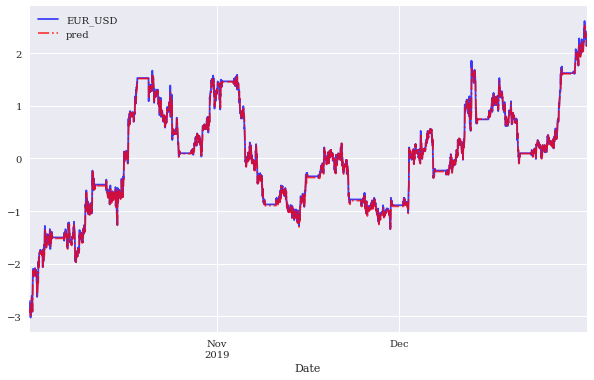

In [21]:
data[[symbol, 'pred']].plot(
    figsize = (10,6), style = ['b','r-.'], 
    alpha = 0.75)

In [22]:
# financial return series 
data = generate_data()
data['r'] = np.log(data/data.shift(1))


In [23]:
data.dropna(inplace = True)
data = (data - data.mean())/data.std()
r = data['r'].values
r = r.reshape((len(r), -1))

In [24]:
g = TimeseriesGenerator(r,r,length = lags, batch_size = 5)

In [25]:
model = create_rnn_model()


In [26]:
%%time
model.fit_generator(g, epochs = 500, steps_per_epoch = 10, 
                   verbose = False)

CPU times: user 41 s, sys: 2.96 s, total: 43.9 s
Wall time: 17.9 s


In [27]:
y = model.predict(g, verbose = False)

In [28]:
data['pred'] = np.nan
data['pred'].iloc[lags:] = y.flatten()
data.dropna(inplace = True)


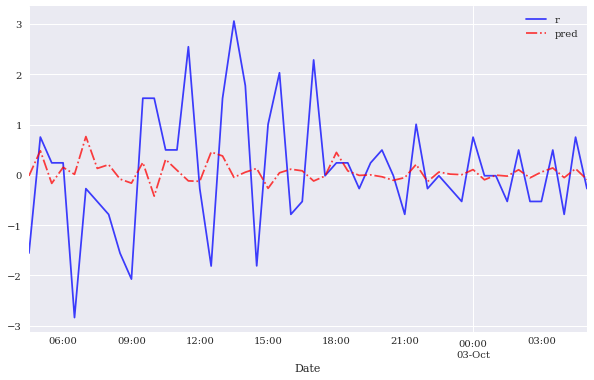

In [30]:
data[['r', 'pred']].iloc[50:100].plot(
    figsize = (10,6), style = ['b','r-.'], 
    alpha = 0.75);

In [33]:
# RNN performs better on the return than price series?

from sklearn.metrics import accuracy_score
accuracy_score(np.sign(data['r']), np.sign(data['pred']))

0.678838738943071

In [35]:
# calculate accuracy score out of sample
split = int(len(r*0.8))
train = r[:split]
test = r[split:]
g = TimeseriesGenerator(train,train, length = lags, batch_size = 5)


In [37]:
def set_seeds(seed = 100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
set_seeds()

In [40]:
model = create_rnn_model(hu = 100)



In [43]:
%%time
model.fit_generator(g, epochs = 100, steps_per_epoch = 10, verbose = False)

CPU times: user 7.79 s, sys: 559 ms, total: 8.35 s
Wall time: 3.34 s


In [47]:
g_ = TimeseriesGenerator(test,test,length = lags, batch_size = 5)


ValueError: `start_index+length=5 > end_index=-1` is disallowed, as no part of the sequence would be left to be used as current step.

In [45]:
y = model.predict(g_)

NameError: name 'g_' is not defined

In [46]:
lags

5

In [48]:
# financial features to improve the predictive capability of RNN
data = generate_data()
data['r'] = np.log(data/data.shift(1))
window = 20
data['mom'] = data['r'].rolling(window).mean()
data['vol'] = data['r'].rolling(window).std()
data.dropna(inplace = True)

In [49]:
split = int(len(data)* 0.8)
train = data.iloc[:split].copy()
mu, std = train.mean(), train.std()
train = (train - mu)/std # gaussian normalization to the training data
test = data.iloc[split:].copy()
test = (test-mu)/std


In [50]:
g = TimeseriesGenerator(train.values, train['r'].values, length = lags, 
                        batch_size = 5)
set_seeds()
model = create_rnn_model(hu = 100, features = len(data.columns), layer = 'SimpleRNN')


In [51]:
model.fit_generator(g, epochs = 100, steps_per_epoch = 10, verbose = False)

In [52]:
g_ = TimeseriesGenerator(test.values, test['r'].values, length = lags, 
                         batch_size = 5)
y = model.predict(g_).flatten()

In [53]:
accuracy_score(np.sign(test['r'].iloc[lags:]), np.sign(y))

0.35697940503432496

In [54]:
# classification
set_seeds()
model = create_rnn_model(hu = 50, features = len(data.columns),
                        layer = 'LSTM',
                        algorithm = 'classification')

In [55]:
train_y = np.where(train['r'] > 0, 1, 0)
np.bincount(train_y)

array([2374, 1142])

In [59]:
def cw(a):
    c0,c1 = np.bincount(a)
    w0 = (1/c0) * (len(a))/2
    w1 = (1/c1) * (len(a))/2
    return {0:w0, 1:w1}

In [60]:
g = TimeseriesGenerator(train.values, train_y, length = lags, batch_size=5)


In [61]:
%%time
model.fit_generator(g,epochs = 5, steps_per_epoch = 10, verbose = False,
                   class_weight = cw(train_y))


CPU times: user 2.26 s, sys: 195 ms, total: 2.45 s
Wall time: 1.97 s


In [62]:
test_y = np.where(test['r']>0,1,0)
g_ = TimeseriesGenerator(test.values, test_y, 
                         length = lags, batch_size = 5)
y = np.where(model.predict(g_, batch_size = None)>0.5,1,0).flatten()

In [63]:
np.bincount(y)

array([480, 394])

In [64]:
accuracy_score(test_y[lags:],y)

0.6475972540045767

In [75]:
# deep RNNs which are rnns with multiple hidden layers
# possible to add dropout to avoid overfitting

from keras.layers import Dropout 

def create_deep_rnn_model(hl = 2, hu = 100,layer = 'SimpleRNN',optimizer = 'rmsprop',
                          features = 1,dropout = False, rate = 0.3, seed = 100):
    if hl<=2: hl = 2
    if layer == 'SimpleRNN':
        layer = SimpleRNN
    else:
        layer = LSTM
    model = Sequential()
    model.add(layer(hu, input_shape = (lags, features),
                    return_sequences = True,
                   ))
    if dropout:
        model.add(Dropout(rate, seed = seed))
    for _ in range(2,hl):
        model.add(layer(hu,return_sequences = True))
        if dropout:
            model.add(Dropout(rate, seed = seed))
    model.add(layer(hu))
    model.add(Dense(1,activation = 'sigmoid'))
    model.compile(optimizer = optimizer, 
                 loss = 'binary_crossentropy', 
                 metrics = ['accuracy'])
    return model
    

In [76]:
set_seeds()
model = create_deep_rnn_model(
    hl = 2, hu = 50, layer = 'SimpleRNN', features = len(data.columns), 
    dropout = True, rate = 0.3)



In [77]:
%%time
model.fit_generator(g, epochs = 200, steps_per_epoch = 10, 
                   verbose = False, class_weight = cw(train_y))

CPU times: user 29.3 s, sys: 2.16 s, total: 31.5 s
Wall time: 13 s


In [78]:
y = np.where(model.predict(g_, batch_size = None)>0.5, 1, 0).flatten()

In [79]:
np.bincount(y)

array([475, 399])

In [80]:
accuracy_score(test_y[lags:],y)

0.6006864988558352

In [ ]:
# timeseriesGenerator converts sequential data to a generator object that keras 
# RNN can work with



